# Explorative Data Analysis

Pontus' notebook for testing EDA, copy successful/good ideas to main EDA

In [40]:
# Import packages
import json
import pandas as pd  
import numpy as np
from tqdm.notebook import tqdm

In [225]:
# Read data
train = pd.read_json('data/train.json', lines=True) 
test = pd.read_json('data/test.json', lines=True) 
# Divide test data into the two subsets: Private Test and Public Test
# seq_length=107 in Public Test while seq_length=130 in Private Test
test_public = test[test["seq_length"] == 107]
test_private = test[test["seq_length"] == 130]

# Print the first sample for testing
df = pd.DataFrame(train)
df.iloc[0]

# Optionally, only take training data which have passed the signal-to-noise filter
train_filtered = train[train["SN_filter"] == 1]

# Change apply_SN_filter to True to only train on filtered data, using the SN filter described in the Kaggle challenge (same which is used for public test data)
apply_SN_filter = True
# apply_SN_filter = False 
if apply_SN_filter == True:
    train = train_filtered


The Kaggle challenge authors describe the different columns of the data as follows:

(copied from https://www.kaggle.com/c/stanford-covid-vaccine/data?select=sample_submission.csv)


* `id` - An arbitrary identifier for each sample.

* `seq_scored` - (68 in Train and Public Test, 91 in Private Test) Integer value denoting the number of positions used in scoring with predicted values. This should match the length of reactivity, deg_* and *_error_* columns. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.

* `seq_length` - (107 in Train and Public Test, 130 in Private Test) Integer values, denotes the length of sequence. Note that molecules used for the Private Test will be longer than those in the Train and Public Test data, so the size of this vector will be different.

* `sequence` - (1x107 string in Train and Public Test, 130 in Private Test) Describes the RNA sequence, a combination of A, G, U, and C for each sample. Should be 107 characters long, and the first 68 bases should correspond to the 68 positions specified in seq_scored (note: indexed starting at 0).

* `structure` - (1x107 string in Train and Public Test, 130 in Private Test) An array of (, ), and . characters that describe whether a base is estimated to be paired or unpaired. Paired bases are denoted by opening and closing parentheses e.g. (....) means that base 0 is paired to base 5, and bases 1-4 are unpaired.

* `reactivity` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likely secondary structure of the RNA sample.

* `deg_pH10` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high pH (pH 10).

* `deg_Mg_pH10` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium in high pH (pH 10).

* `deg_50C` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating without magnesium at high temperature (50 degrees Celsius).

* `deg_Mg_50C` - (1x68 vector in Train and Public Test, 1x91 in Private Test) An array of floating point numbers, should have the same length as seq_scored. These numbers are reactivity values for the first 68 bases as denoted in sequence, and used to determine the likelihood of degradation at the base/linkage after incubating with magnesium at high temperature (50 degrees Celsius).

* `*_error_*` - An array of floating point numbers, should have the same length as the corresponding reactivity or deg_* columns, calculated errors in experimental values obtained in reactivity and deg_* columns.

* `predicted_loop_type` - (1x107 string) Describes the structural context (also referred to as 'loop type')of each character in sequence. Loop types assigned by bpRNA from Vienna RNAfold 2 structure. From the bpRNA_documentation: S: paired "Stem" M: Multiloop I: Internal loop B: Bulge H: Hairpin loop E: dangling End X: eXternal loop
    * `S/N filter` Indicates if the sample passed filters described in Additional Notes. (see Data under the Kaggle challenge page)


### Notes and observations about the data
Columns which describe the structure of each sample/molecule:
* The samples consists of a `sequence` of bases of length `seq_length`. The four possible bases in RNA are A, G, U and C. 
* RNA molecules have pairings between some of the bases. The estimated pairings are given by `structure`. 
    * These are however only the pairings determined to be the most likely. Alternative pairings are given by the files in the folder `bpps`, described as the *base pair probabilities* for each base-base pair in the sequence given as an adjacency matrix for each sample.  
* `predicted_loop_type` assign a loop type for each base, which describe the for that base in the sequence. For example, a paired base always (this should be confirmed with code) has loop type S for *stem loop* (see https://en.wikipedia.org/wiki/Stem-loop). Unpaired bases can have a number of different loop types, depending on the structural context of that base (how the molecule is shaped in that part of the sequence).
    * "Predicted" indicates that these are only estimated loop types for the given sequence, much like how `sequence` is the most likely pairings for the sequence. One could look further into alternative loop types for alternative structures, but in the scope of the project the provided loop type should suffice.

Columns which correspond to experimental ground truth values (targets in prediction):
* There are 5 "ground truth" values to be predicted (targets): `reactivity`, `deg_pH10`, `deg_Mg_pH10`, `deg_50C` and `deg_Mg_50C`. They are arrays of floats, where each value describe the reactivity at a given base. They are ordered in the same way as `sequence` but have length `seq_scored`, which is smaller than `seq_length`, meaning that only the first `seq_scored` bases have ground truth (target) values. This is because the reactivity values of the final bases in the sequence can't be measured experimentally due to technical limitations.
* Targets with names `deg_*` describe the likelihood of degradation at the base (my interpretation being the likelihood of the molecule breaking at that node), where `*` specify the conditions for the degradation rates (i.e. at 50 degrees Celcius, or in pH 10). The reactivity values in `reactivity` describe the likely *secondary structure* of the RNA molecule. ("Secondary structure" is a technical term, see https://en.wikipedia.org/wiki/Nucleic_acid_secondary_structure). For the purposes of this project, the 5 target values can be seen as parameters which are important for understanding the degradation of RNA molecules.
* The 5 ground truths/targets also have corresponding vectors `reactivity_error`, `deg_error_pH10` etc., which are estimated experimental errors for the reactivity values. These could be ignored initially, but are likely useful for model performance if included in some relevant way.

Note that `test.json` includes both the Public Test and Private Test data. The two subsets have to be separated by looking at the `seq_length` variable, which should be `107` for Public Test and `130` for Private Test.

Also note the signal to noise, and the SN filter (these are described further on the Kaggle challenge page). Possibly want to exculde the "noisy" samples. 

### In summary
* Each data sample is a sequence of `seq_length` bases
* Each base `i` has the following features
    * `sequence[i]`: char, possible values are `A`, `G`, `U`, `C`
    * `predicted_loop_type[i]`: char, possible values are `S`, `M`, `I`, `B`, `H`, `E`, `X`
    * `sequence[i]`: char, possible values are `.`, `(`, `)`
* The first `seq_scored` bases of the sequence have five ground truth target values each, as well as experimental errors for those five target values
    * `reactivity[i]`, `deg_pH10[i]`, `deg_Mg_pH10[i]`, `deg_50C[i]` and `deg_Mg_50C[i]`: floats, ground truth values for base `i`
    * `reactivity_error[i]`, `deg_error_pH10[i]`, `deg_error_Mg_pH10[i]`, `deg_error_50C[i]` and `deg_error_Mg_50C[i]`: floats, errors of ground truth values for base `i`


## Construct structure adjacency matrix from `structure`
This is copied and adapted from https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn.

Here, only paired bases from `(` `)` pairs are included as edges, and not the connections along the sequence between bases $(0,1)$, $(1,2)$ etc.

The final adjacency matrix could include the following edge features:
* Some distance measure, capturing information from sequence neighbors, diminishing with index distance (i.e. Manhattan distance)
* The provided base pairs, given by `structure`. This is implemented in the current function
* The given base pair probabilities, given by files in the `bpps`
Either, one could use separate graph convolutions for each edge feature, and somehow concatenate the results before mapping to targets, for example by using some pooling layer.
Or, one could use an encoder, to reduce the edge features to a single adjacency matrix. (This is what Sam is looking at)

In [226]:
## get adjacent matrix from structure sequence

## here I calculate adjacent matrix of each base pair, 
## but eventually ignore difference of base pair and integrate into one matrix
Ss = []
for i in range(len(train)):
    seq_length = train["seq_length"].iloc[i]
    structure = train["structure"].iloc[i]
    sequence = train["sequence"].iloc[i]

    cue = []
    a_structures = {
        ("A", "U") : np.zeros([seq_length, seq_length]),
        ("C", "G") : np.zeros([seq_length, seq_length]),
        ("U", "G") : np.zeros([seq_length, seq_length]),
        ("U", "A") : np.zeros([seq_length, seq_length]),
        ("G", "C") : np.zeros([seq_length, seq_length]),
        ("G", "U") : np.zeros([seq_length, seq_length]),
    }
    a_structure = np.zeros([seq_length, seq_length])
    for i in range(seq_length):
        if structure[i] == "(":
            cue.append(i)
        elif structure[i] == ")":
            start = cue.pop()
#                 a_structure[start, i] = 1
#                 a_structure[i, start] = 1
            a_structures[(sequence[start], sequence[i])][start, i] = 1
            a_structures[(sequence[i], sequence[start])][i, start] = 1
    
    a_strc = np.stack([a for a in a_structures.values()], axis = 2)
    a_strc = np.sum(a_strc, axis = 2, keepdims = True)
    Ss.append(a_strc)

Ss = np.array(Ss)
print(Ss.shape)

(1589, 107, 107, 1)


The resulting adjacency matrix is stored as `Ss`. 
All pairs are treated equally, the `("A", "U")` arrays are concatenated into one adjacency matrix.

The shape of `Ss` is `(number_of_samples, seq_length, seq_length, 1)`.
In their implementation, the last dimension is later used for stacking multiple adjacency matrices with different information, e.g. distance adjacency matrix and base-pair probability adjacency matrices.

In [227]:
# Check number of pairs (edges)
np.sum(Ss[0,:,:,0] == 1)

46

In [228]:
# Count number of "(", should be half of number of pairs
np.sum(Ss[0,:,:,0] == 1)
counter_left_pair = 0
for char in train["structure"].iloc[0]:
  if char == "(":
    counter_left_pair += 1
counter_left_pair

23

In [229]:
Ss[0,:,:,0]
struct_adj = Ss[0,:,:,0] # Reshape to (seq_length,seq_length)

### Rewrite function that creates adjacency matrix, only including necessary steps

In [230]:
def get_struct_adj(data = train, sequential_edges = False):
    # Get adjacency matrix from sample structure sequence
    # Include edges between base pairs
    # If sequential_edges == False, do not include edges between sequential bases
    # If sequential_edges == True, add these edges, which correspond to the diagonals -1 and 1 in the adjacency matrix (assuming undirected edges)
    struct_adj = []
    for ix in range(len(data)):
        seq_length = data["seq_length"].iloc[ix]
        structure = data["structure"].iloc[ix]
        sequence = data["sequence"].iloc[ix]

        queue = [] # Store indices corresponding to "(" in queue

        sample_struct_adj = np.zeros([seq_length, seq_length])
        for jx in range(seq_length):
            if structure[jx] == "(":
                queue.append(jx) # Append index of "(" in base pair to queue
            elif structure[jx] == ")":
                start = queue.pop() # Retrieve index of last "(" in queue, corresponding to ")" at jx
                sample_struct_adj[start, jx] = 1 # Add edge from "(" to ")"
                sample_struct_adj[jx, start] = 1 # Add edge from ")" to "(" (assume undirected)

        if sequential_edges == True:
            ones = np.ones(seq_length-1) # Match length of -1 and 1 diagonals in sample_struct_adj
            sample_struct_adj += np.diag(ones,1) # Add sequential edges (i,i+1) 
            sample_struct_adj += np.diag(ones,-1) # Add sequential edges (i+1,i) (assume non-directed)

        struct_adj.append(sample_struct_adj)

    struct_adj = np.array(struct_adj)
    return struct_adj 

In [231]:
mySs = get_struct_adj(data = train)
print(mySs.shape)
mySs = mySs[:,:,:,np.newaxis] # Reshape to match structure adjacency from reference
print(mySs.shape)

# Check that the implementation is equivalent to reference
np.array_equal(Ss,mySs)

(1589, 107, 107)
(1589, 107, 107, 1)


True

## Try to plot the graph from adjacency matrix
Include off-diagonal ones for sequential edges

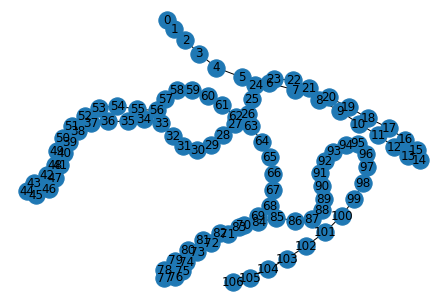

In [93]:
import networkx as nx 
  
A  =  get_struct_adj(data=train, sequential_edges=True) # Include sequential edges
A = A[0,:,:] # Take adjacency matrix of first sample

# ones = np.ones(seq_length-1)
# A += np.diag(ones,1) # add sequential edges (i,i+1) 
# A += np.diag(ones,-1) # add sequential edges (i+1,i) (assume non-directed)

G = nx.from_numpy_matrix(np.array(A))
nx.draw(G, with_labels=True)

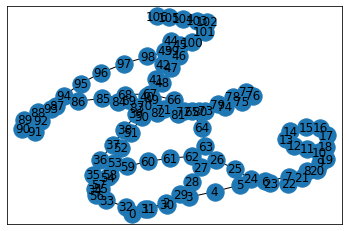

In [94]:
#  Try to make graph non-overlapping?
spring = nx.spring_layout(G)
nx.draw_networkx(G,spring)

## Look at bpps (first sample in training data)

In [232]:
a = np.load('data/bpps/id_001f94081.npy') 
print(a.shape)

(107, 107)


In [233]:
# Look at edges for one of the paired bases (row index 5)
struct_adj[5,:]
bpps_base5 = a[5,:]

In [234]:
np.where(struct_adj[5,:] == 1) # Find pair of base with index 5

(array([24], dtype=int64),)

In [235]:
np.argmax(bpps_base5) # Find maximum base pair probability for base with index 5

24

Maximum bpps value matches the true adjacency matrix (for this sample at least). Suggests that the predicted structure is based on the most likely base pairs from bpps.

## Distance matrix in reference notebook 
How the distance adjacency matrix is constructed in https://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn#distance-adjhttps://www.kaggle.com/mrkmakr/covid-ae-pretrain-gnn-attn-cnn#distance-adj

In [236]:
# Example snippet of creating distance matrix for training sample, where seq_length=107
idx = np.arange(train["seq_length"].iloc[0])
Ds = []
for i in range(len(idx)):
    d = np.abs(idx[i] - idx)
    Ds.append(d)
print(Ds[0]) # Before converting absolute index distance to distance measure
# Here Ds is a list of seq_length arrays, each with length seq_length

Ds = np.array(Ds) + 1
Ds = 1/Ds
Ds = Ds[None, :,:] # Expand the dimensions of the array to allow stacking matrices for all samples 
print(Ds.shape)
Ds = np.repeat(Ds, len(train), axis = 0) # Repeat the distance array for each sample (even though they are identical)
# Here, Ds is transformed to the distance measured and reshaped into adjacency matrices for each sample, with values being the distance measure between nodes
print(Ds.shape)

Dss = []
for i in [1, 2, 4]: 
    Dss.append(Ds ** i)
Ds = np.stack(Dss, axis = 3)
print(Ds.shape)
# Here, the power in the denominator of the distance measure expression is applied, resulting in 3 different distance adjacency matrices for each sample

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106]
(1, 107, 107)
(1589, 107, 107)
(1589, 107, 107, 3)


The distance matrices are equal for every sample in a given data set, the only inputs are the length of the sample. In the reference notebook, they use `As` (the stacked array of base-pair probability matrices) as an argument when constructing the distance matrix, but `As` is only used to determine `seq_length` and the number of samples in each data subset. The distance between bases at indices $i$ and $j$ is defined as

$$D(i,j) = \frac{1}{(|i - j| + 1)^p}$$

where $p$ is set to $1$, $2$ and $4$, giving three different measures of distance. The resulting distance adjacency matrices are stacked together with the structure adjacency matrix and the base-pair probability matrices given by the files in the `bpps` folder.

In [237]:
# Function for constructing distance adjacency matrix
# Only returns one distance adjacency matrix, since it is identical for all samples (only depends on number of nodes)
def get_dist_adj(data = train, power = 1):
    # Get adjacency matrix from inverse index-based distance between nodes
    # power is the variable p in the expression D(i,j)
    dist_adj = []
    idx = np.arange(data["seq_length"].iloc[0]) # Get number of nodes
    for ix in range(len(idx)):
        d = np.abs(idx[i] - idx) # Get distance from individual nodes to all other nodes
        dist_adj.append(d)

    # Convert distance to distance measure according to formula    
    dist_adj = np.array(dist_adj) + 1 # Add one to avoid singularity at d=0
    dist_adj = 1/dist_adj # Inverse of distance
    dist_adj = dist_adj**power # Apply the specified power
    return dist_adj 

## Construct node feature vectors/arrays

Looked at node feature array in reference notebook, but things seemed overly complicated. Will implement it myself, and can compare later to make sure that everything is understood correctly.

Currently, the included node features are:

* The base of the node, one-hot encoded. One of `'A'`, `'G'`, `'U'`, `'C'` (4 features)
* The provided predicted loop type of the node, one-hot encoded. One of `'S'`, `'M'`, `'I'`, `'B'`, `'H'`, `'E'`, `'X'` (7 features)

This results in a total of 11 node features. One could of course include more node features. These are the provided obvious ones.

In [238]:
def get_node_features(data = train):
    # Create a node feature matrix for each sample in data
    # Encode feature vectors as one-hot arrays  
    # Included features: 
    #   Base (given by sequence)
    #   Loop type (given by predicted_loop_type)
    # Could also include sequence, i.e. "." "(" and ")", but I don't see how this provides any interesting information if the structure adjacency matrix is used
    X = [] # Stacked node feature matrices for all samples in data
    
    for ix in range(len(data)):
        seq_length = data["seq_length"].iloc[ix]
        sequence = train["sequence"].iloc[ix]
        predicted_loop_type = train["predicted_loop_type"].iloc[ix]

        X_sample = [] # Node feature matrix for current sample

        for jx in range(seq_length):
            # Base one hot
            bases = np.array(['A', 'G', 'U', 'C']) # Different order than reference notebook (A,G,C,U)
            x_base = np.zeros(len(bases))
            x_base[bases == sequence[jx]] = 1 # Set base one-hot to 1 at correct index

            # Predicted Loop Type one hot
            loop_types = np.array(['S', 'M', 'I', 'B', 'H', 'E', 'X'])
            x_loop = np.zeros(len(loop_types))
            x_loop[loop_types == predicted_loop_type[jx]] = 1 # Set loop-type one-hot to 1 at correct index

            x = np.concatenate((x_base,x_loop)) # Concatenate to one node feature vector
            X_sample.append(x) # Append node feature vector to node feature matrix
        X_sample = np.array(X_sample)
        X.append(X_sample) # Append node feature matrix for current graph
    X = np.array(X)
    return X
X_tr = get_node_features(train)

In [239]:
print(X_tr.shape)
# Print feature vector of node 42 in sample 0 to see that the function assigns one hot correctly
print(X_tr[0,42])
print(train["sequence"].iloc[0][42])
print(train["predicted_loop_type"].iloc[0][42])
# First 4 are sequence one hot, last 7 are loop type one hot

(1589, 107, 11)
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
G
S


Try using reference notebook implementation of node features for comparison.

In [240]:
## sequence
def return_ohe(n, i):
    tmp = [0] * n
    tmp[i] = 1
    return tmp

def get_input(train):
    ## get node features, which is one hot encoded
    mapping = {}
    vocab = ["A", "G", "C", "U"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_node = np.stack(train["sequence"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))

    mapping = {}
    vocab = ["S", "M", "I", "B", "H", "E", "X"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_loop = np.stack(train["predicted_loop_type"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    mapping = {}
    vocab = [".", "(", ")"]
    for i, s in enumerate(vocab):
        mapping[s] = return_ohe(len(vocab), i)
    X_structure = np.stack(train["structure"].apply(lambda x : list(map(lambda y : mapping[y], list(x)))))
    
    
    X_node = np.concatenate([X_node, X_loop], axis = 2)
    
    ## interaction
    a = np.sum(X_node * (2 ** np.arange(X_node.shape[2])[None, None, :]), axis = 2)
    vocab = sorted(set(a.flatten()))
    print(vocab)
    ohes = []
    for v in vocab:
        ohes.append(a == v)
    ohes = np.stack(ohes, axis = 2)
    X_node = np.concatenate([X_node, ohes], axis = 2).astype(np.float32)
    
    
    print(X_node.shape)
    return X_node

X_node = get_input(train)

[17, 18, 20, 24, 33, 34, 36, 40, 65, 66, 68, 72, 129, 130, 132, 136, 257, 258, 260, 264, 513, 514, 516, 520, 1025, 1026, 1028, 1032]
(1589, 107, 39)


In [241]:
print(X_tr[0,42])
print(X_node[0,42])

[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Encoding of base and loop types are identical apart from ordering of bases (AGUC here, AGCU in reference). Reference uses one additional one-hot encoded feature called "interaction" with 28 possible values. Could look into what this is and if it is of interest.

## Construct target arrays
Include all 5 targets, even though only 3 are scored, as this can be expected to improve the inference on the test data. This is equivalent to reference notebook, but there they expand the target vectors to match `seq_length` with entries -10000 for the unknown target values. This is maybe a more convenient way to implement it, to have consisten sizes of all arrays.

In [242]:
target_labels = ["reactivity", "deg_Mg_pH10", "deg_Mg_50C", "deg_pH10", "deg_50C"]

y_train = []
seq_length = train["seq_length"].iloc[0] # Get number of nodes (lenght of sequence)
seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
for target in target_labels:
    y = np.vstack(train[target]) # Create (n_samples, seq_scored) arrays for each target
    y_train.append(y) # Append array for each target
y_train = np.stack(y_train, axis=2) # Join the target arrays along last axis to match shape of feature arrays
print(y_train.shape)


(1589, 68, 5)


## Try to implement a graph neural network
Use feature matrix and adjacency matrix (only pair edges) from training data for initial test.

Start with network architecture from Homework A, dataset 2. We are essentially doing supervised graph classification, but we want to keep the labels for each node. This is similar to what was done in Homework A, except that we don't want to use a final pooling layer to classify the enitre graph. Instead, we keep the target vector from each node and calculate a loss from that, so each graph gives a single loss value (for example mean columnwise root mean square error, MCRMSE). 


In [243]:
X = get_node_features(train)
print(X.shape)
A_pairs = get_struct_adj(data = train)
print(A_pairs.shape)

(1589, 107, 11)
(1589, 107, 107)


In [244]:
import torch
from torch.nn import Linear
from torch.nn import ReLU
import torch.nn.functional as F

In [245]:
# Need to install CUDA, or some missing path problem. Skip torch-geometric for now, can write GraphConv manually
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.1+cpu.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.1+cpu.html
# !pip install -q torch-geometric

# from torch_geometric.nn import GraphConv
# from torch_geometric.nn import global_mean_pool
# from torch.nn import LogSoftmax

Define the graph convolution operator. Due to trouble with installation of torch-geometric, I'll write my own GraphConv operator. 

In [246]:
class myGraphConv(torch.nn.Module):
    """
    The graph neural network operator from the “Weisfeiler and Leman Go 
    Neural: Higher-order Graph Neural Networks” paper

    x' = x_i W_1.T + (Adj x_i) W_2.T

    Arguments:
        in_channels (int): Number of features (size) of each input node
        out_channels (int): Number of features (size) of each output node
    
    forward performs the graph neural network operation
    Arguments:
        x (torch tensor): The input node features of shape (n_nodes, in_channels) 
        Adj (torch tensor): The adjacency matrix of the graph of shape (n_nodes, n_nodes)
    Returns: 
        x' (torch tensor): Output node feature matrix of shape (n_nodes, out_channels)
    """
    # Notes:
    ## Possibly change to allow x of shape (n_samples, n_nodes, in_channels) 
    ## and Adj of shape (n_samples, n_nodes, n_nodes).
    ## Also should add boolean argument bias for the linear weights.
    ## GraphConv seems to only use bias for W_2 if I understand the source code correctly
    ## (see lin_r = ... bias=False).a


    def __init__(self, in_channels, out_channels):
        super(myGraphConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.lin_1 = Linear(in_channels, out_channels, bias=True) # bias=False to match GraphConv? Check source code
        self.lin_2 = Linear(in_channels, out_channels, bias=True)  

        self.reset_parameters()
   
    def reset_parameters(self):
        self.lin_1.reset_parameters()
        self.lin_2.reset_parameters()

    def forward(self, x, Adj):
        # Shapes of arguments, weight matrices and output
        # x: (n_nodes, in_channels)
        # Adj: (n_nodes, n_nodes)
        # W_1: (in_channels, out_channels)
        # W_2: (in_channels, out_channels)
        # out: (n_nodes, out_channels)
        out = torch.matmul(Adj,x) # Calculate contributions from adjacent nodes, this is equivalent to summing over edge weights assuming Adj contains the edge weights
        out = self.lin_2(out) # Multiply with weight matrix for adjacent nodes
        out += self.lin_1(x) # Add contribution from self
        return out

    # The method that returns a printable representation of the operator, copy to match GraphConv source code 
    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


Build the model. As a starting point, modify the code from Homework A, dataset 2. Use a simple model to begin with.

In [247]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345) # For reproducible results
        self.conv = myGraphConv(X.shape[2], hidden_channels) # This uses my implementation of GraphConv. Change to torch-geometric version when possible
        self.lin = Linear(hidden_channels, 5) # Map to the 5 output targets with dense layer
        self.relu = ReLU()

    def forward(self, x, Adj):
        # 1. Obtain node embeddings, use GraphConv layers with ReLU for non-linearity
        x = self.conv(x, Adj) # Give adjacency matrix instead of edge_index and edge_weight
        x = self.relu(x)

        # 2. Readout layer
        # No pooling is required, we want target labels for each node, not for the entire graph

        # 3. Apply a final classifier 
        # Use a single layer as classifier to map to the targets
        x = self.lin(x)

        # No LogSoftmax needed, possibly some other function to map to correct targets?

        return x
    

Define the mean column-wise root mean square error (MCRMSE) loss function, which is the score used in the challenge. Note that while there are 5 targets to be predicted, only three of them are scored: reactivity, degMgpH10, and degMg50C. One could either use all 5 in loss, or just the scored targets to minimize the actual Kaggle challenge score. 
It is probably a good idea to use all targets for the loss during training, as the additional information could improve the inference on the scored targets for the test data.



In [248]:
# Define MCRMSE loss function
# Include all 5 targets by default, allow optional argument to calculate MCRMSE of scored targets only.
# Assumes targets are ordered such that the first 3 targets are the scored ones.
# Inputs should have dimensions (n_samples, n_nodes, n_targets)
def MCRMSE(y_true, y_pred, only_scored=False):
    # Extract the scored targets
    seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
    y_pred = y_pred[:, :seq_scored, :] 
    # true = y_true[:, :seq_scored, :] # Not necessary since only scored targets are included, could include dummy values instead as in reference notebook

    y_diff = y_pred - y_true
    mse = torch.mean(y_diff**2, axis=1) # Average over nodes in each sample for every target
    rmse = torch.sqrt(mse)
    
    num_scored = 5 # Include all targets by default
    if only_scored == True:
        num_scored = 3 # Include only scored targets if specified by keyword (assumes correct ordering of targets in y_true and y_pred)

    mcrmse = torch.mean(rmse[:, :num_scored], axis=1) # Average over included targets

    return mcrmse

Also write a loss function that takes one sample at a time for testing. Merge to one/use the above one when we actually pass batches of data, this is just for a test run.

In [249]:
# Define MCRMSE loss function, taking one sample at a time 
# Inputs should have dimensions (n_nodes, n_targets)
def MCRMSE_single(y_true, y_pred, only_scored=False):
    # Extract the scored targets
    seq_scored = train["seq_scored"].iloc[0] # Get number of nodes with ground truth targets
    y_pred = y_pred[:seq_scored, :] 
    # true = y_true[:seq_scored, :] # Not necessary since only scored targets are included, could include dummy values instead as in reference notebook

    y_diff = y_pred - y_true
    mse = torch.mean(y_diff**2, axis=0) # Average over nodes in each sample for every target
    rmse = torch.sqrt(mse)
    
    num_scored = 5 # Include all targets by default
    if only_scored == True:
        num_scored = 3 # Include only scored targets if specified by keyword (assumes correct ordering of targets in y_true and y_pred)

    mcrmse = torch.mean(rmse[:num_scored]) # Average over included targets

    return mcrmse

Train the network on the training data. For a simple test run, iterate over single samples in the training data. When improving the training routine, we probably want to allow for iteration over batches of data, for example as in k-fold cv. 

In [250]:
# Instantiate GNN model, optimizer and loss function
model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adjust learning rate
criterion = MCRMSE_single # Mean column-wise root mean square error (MCRMSE) loss

# Define trainer function for GNN
def run_training(X_data, Adj_data):
    model.train()
    running_loss = 0 # For printing training loss
    for ix in range(len(X_data)):  # Iterate over samples in the training dataset
        out = model(X_data[ix,:,:], Adj_data[ix,:,:]) # Perform a single forward pass.
    # out = model(X_data, Adj_data) # all in one pass, no for loop
        loss = criterion(torch.tensor(y_train[ix,:,:].astype(float)), out)  # Compute the loss. Convert target vector to float (apparently important for back-propagation)
        loss.backward()  # Derive gradients
        optimizer.step()  # Update parameters based on gradients
        optimizer.zero_grad()  # Clear gradients

        # Print statistics
        running_loss += loss.item()
        if ix % 200 == 199:    # Print average loss every 200 mini-batches (every 200 samples in this case)
            print('[sample %5d] loss: %.3f' %
                    (ix + 1, running_loss / 200))
            running_loss = 0.0 # Reset running loss
# Convert training data inputs to pytorch tensors and run training
X_torch = torch.tensor(X.astype(np.float32))
Adj_torch = torch.tensor(A_pairs.astype(np.float32))
run_training(X_torch, Adj_torch)


GNN(
  (conv): myGraphConv(11, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
)
[sample   200] loss: 0.431
[sample   400] loss: 0.419
[sample   600] loss: 0.410
[sample   800] loss: 0.416
[sample  1000] loss: 0.405
[sample  1200] loss: 0.414
[sample  1400] loss: 0.410


Generate feature arrays and adjacency matrix for public test data. Make predictions on the test data using the trained model.

In [251]:
X_test_public = get_node_features(data = test_public)
print(X_test_public.shape)
A_test_public = get_struct_adj(data = test_public)
print(A_test_public.shape)

(629, 107, 11)
(629, 107, 107)


Make predictions on test data.

In [252]:
# Define prediction function
def run_prediction(X_data, Adj_data):
    model.eval()
    y_pred = []
    for ix in range(len(X_data)): 
        out = model(X_data[ix,:,:], Adj_data[ix,:,:]) # Perform a single forward pass.
        y_pred.append(out.detach().numpy())
    y_pred = np.array(y_pred)
    return y_pred
# Convert test data inputs to pytorch tensors and run prediction
X_test_public_torch = torch.tensor(X_test_public.astype(np.float32))
A_test_public_torch = torch.tensor(A_test_public.astype(np.float32))
y_pred = run_prediction(X_test_public_torch, A_test_public_torch)


In [253]:
print(y_pred.shape)

(629, 107, 5)


The code runs without errors, and the output shapes are correct. Although we don't know if anything reasonable is calculated.

Try making predictions on all training data using the final model, and calculate the score (MCRMSE) on the training data.

In [254]:
# Run prediction on training data as a test run
y_train_pred = run_prediction(X_torch, Adj_torch)

In [255]:
# Calculate score on training data
y_train_torch = torch.tensor(y_train.astype(float))
y_train_pred_torch = torch.tensor(y_train_pred.astype(float))
training_score = MCRMSE(y_train_torch, y_train_pred_torch, only_scored=False)
training_score_only_scored = MCRMSE(y_train_torch, y_train_pred_torch, only_scored=True)

In [256]:
print(f"Mean score on training data, all 5 targets: {float(torch.mean(training_score)):.5}")
print(f"Mean score on training data, only scored targets: {float(torch.mean(training_score_only_scored)):.5}")

Mean score on training data, all 5 targets: 0.40833
Mean score on training data, only scored targets: 0.41908


 Very bad model, but the code runs :)

## Include distance adjacency matrix
Testing 05/17/2021


In [258]:
X = get_node_features(train)
print(X.shape)
A_pairs = get_struct_adj(data = train)
print(A_pairs.shape)
D = get_dist_adj(data = train, power = 1)
print(D.shape)

(1589, 107, 11)
(1589, 107, 107)
(107, 107)


In [259]:
class myGraphConv_test(torch.nn.Module):
    """
    The graph neural network operator from the “Weisfeiler and Leman Go 
    Neural: Higher-order Graph Neural Networks” paper

    x' = x_i W_1.T + (Adj x_i) W_2.T

    Arguments:
        in_channels (int): Number of features (size) of each input node
        out_channels (int): Number of features (size) of each output node
    
    forward performs the graph neural network operation
    Arguments:
        x (torch tensor): The input node features of shape (n_nodes, in_channels) 
        Adj (torch tensor): The adjacency matrix of the graph of shape (n_nodes, n_nodes)
        Dist (torch tensor): The distance adjacency matrix of shape (n_nodes, n_nodes) 
                        
    Returns: 
        x' (torch tensor): Output node feature matrix of shape (n_nodes, out_channels)
    """
    # Notes:
    ## Possibly change to allow x of shape (n_samples, n_nodes, in_channels) 
    ## and Adj of shape (n_samples, n_nodes, n_nodes).
    ## Also should add boolean argument bias for the linear weights.
    ## GraphConv seems to only use bias for W_2 if I understand the source code correctly
    ## (see lin_r = ... bias=False).a
    ## Write generalized code for adjacency matrix with arbitrary number of edge features 


    def __init__(self, in_channels, out_channels):
        super(myGraphConv_test, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.lin_1 = Linear(in_channels, out_channels, bias=True) # bias=False to match GraphConv? Check source code
        self.lin_2 = Linear(in_channels, out_channels, bias=True)  
        self.lin_3 = Linear(in_channels, out_channels, bias=True)

        self.reset_parameters()
   
    def reset_parameters(self):
        self.lin_1.reset_parameters()
        self.lin_2.reset_parameters()
        self.lin_3.reset_parameters()

    def forward(self, x, Adj, Dist):
        # Shapes of arguments, weight matrices and output
        # x: (n_nodes, in_channels)
        # Adj: (n_nodes, n_nodes)
        # Dist: (n_nodes, n_nodes)
        # W_1: (in_channels, out_channels)
        # W_2: (in_channels, out_channels)
        # out: (n_nodes, out_channels)
        out = torch.matmul(Adj,x) # Calculate contributions from adjacent nodes, this is equivalent to summing over edge weights assuming Adj contains the edge weights
        out = self.lin_2(out) # Multiply with weight matrix for adjacent nodes
        out_D = torch.matmul(Dist,x) # Calculate contribution from distance adjacency matrix
        out_D = self.lin_3(out_D) # Multiply with weight matrix for distance measure
        out += out_D # Add contribution from distance measure
        out += self.lin_1(x) # Add contribution from self
        return out

    # The method that returns a printable representation of the operator, copy to match GraphConv source code 
    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [260]:
class GNN_test(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN_test, self).__init__()
        torch.manual_seed(12345) # For reproducible results
        self.conv = myGraphConv_test(X.shape[2], hidden_channels) # This uses my implementation of GraphConv. Change to torch-geometric version when possible
        self.lin = Linear(hidden_channels, 5) # Map to the 5 output targets with dense layer
        self.relu = ReLU()

    def forward(self, x, Adj, Dist):
        # 1. Obtain node embeddings, use GraphConv layers with ReLU for non-linearity
        x = self.conv(x, Adj, Dist) # Give adjacency matrix instead of edge_index and edge_weight
        x = self.relu(x)

        # 2. Readout layer
        # No pooling is required, we want target labels for each node, not for the entire graph

        # 3. Apply a final classifier 
        # Use a single layer as classifier to map to the targets
        x = self.lin(x)

        # No LogSoftmax needed, possibly some other function to map to correct targets?

        return x

In [261]:
# Instantiate GNN model, optimizer and loss function
model_test = GNN_test(hidden_channels=64)
print(model_test)
optimizer = torch.optim.Adam(model_test.parameters(), lr=0.01) # Adjust learning rate
criterion = MCRMSE_single # Mean column-wise root mean square error (MCRMSE) loss
losses = []
# Define trainer function for GNN
def run_training_test(X_data, Adj_data, D_data):
    model_test.train()
    running_loss = 0 # For printing training loss
    for ix in range(len(X_data)):  # Iterate over samples in the training dataset
        out = model_test(X_data[ix,:,:], Adj_data[ix,:,:], D_data) # Perform a single forward pass.
    # out = model_test(X_data, Adj_data) # all in one pass, no for loop
        loss = criterion(torch.tensor(y_train[ix,:,:].astype(float)), out)  # Compute the loss. Convert target vector to float (apparently important for back-propagation)
        loss.backward()  # Derive gradients
        optimizer.step()  # Update parameters based on gradients
        optimizer.zero_grad()  # Clear gradients

        # Print statistics
        running_loss += loss.item()
        if ix % 200 == 199:    # Print average loss every 200 mini-batches (every 200 samples in this case)
            print('[sample %5d] loss: %.3f' %
                    (ix + 1, running_loss / 200))
            running_loss = 0.0 # Reset running loss
        # Save loss
        losses.append(loss.detach().numpy())
# Convert training data inputs to pytorch tensors and run training
X_torch = torch.tensor(X.astype(np.float32))
Adj_torch = torch.tensor(A_pairs.astype(np.float32))
D_torch = torch.tensor(D.astype(np.float32))
run_training_test(X_torch, Adj_torch, D_torch)


GNN_test(
  (conv): myGraphConv_test(11, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
)
[sample   200] loss: 0.433
[sample   400] loss: 0.401
[sample   600] loss: 0.384
[sample   800] loss: 0.399
[sample  1000] loss: 0.382
[sample  1200] loss: 0.397
[sample  1400] loss: 0.388


In [262]:
import matplotlib.pyplot as plt

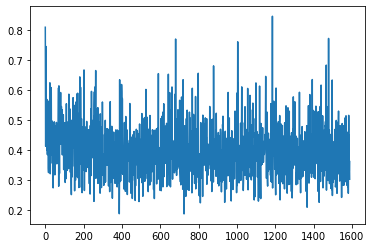

In [263]:
plt.plot(losses)

In [264]:
# Define prediction function for test network
def run_prediction_test(X_data, Adj_data, D_data):
    model.eval()
    y_pred = []
    for ix in range(len(X_data)): 
        out = model_test(X_data[ix,:,:], Adj_data[ix,:,:], D_data) # Perform a single forward pass.
        y_pred.append(out.detach().numpy())
    y_pred = np.array(y_pred)
    return y_pred
# Convert test data inputs to pytorch tensors and run prediction
X_test_public_torch = torch.tensor(X_test_public.astype(np.float32))
A_test_public_torch = torch.tensor(A_test_public.astype(np.float32))
y_pred = run_prediction_test(X_test_public_torch, A_test_public_torch, D_torch)


In [265]:
# Run prediction on training data as a test run
y_train_pred = run_prediction_test(X_torch, Adj_torch, D_torch)

In [266]:
# Calculate score on training data
y_train_torch = torch.tensor(y_train.astype(float))
y_train_pred_torch = torch.tensor(y_train_pred.astype(float))
training_score = MCRMSE(y_train_torch, y_train_pred_torch, only_scored=False)
training_score_only_scored = MCRMSE(y_train_torch, y_train_pred_torch, only_scored=True)

In [267]:
print(f"Mean score on training data, all 5 targets: {float(torch.mean(training_score)):.5}")
print(f"Mean score on training data, only scored targets: {float(torch.mean(training_score_only_scored)):.5}")

Mean score on training data, all 5 targets: 0.39366
Mean score on training data, only scored targets: 0.40764


## Make a basic MLP for comparison
Testing 17/5/2021

In [268]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345) # For reproducible results
        self.hidden = Linear(X.shape[2], hidden_channels)
        self.lin = Linear(hidden_channels, 5) # Map to the 5 output targets with dense layer
        self.relu = ReLU()

    def forward(self, x):
        # 1. Obtain node embeddings, use GraphConv layers with ReLU for non-linearity
        x = self.hidden(x)
        x = self.relu(x)

        # 2. Readout layer
        # No pooling is required, we want target labels for each node, not for the entire graph

        # 3. Apply a final classifier 
        # Use a single layer as classifier to map to the targets
        x = self.lin(x)

        # No LogSoftmax needed, possibly some other function to map to correct targets?

        return x

In [269]:
# Instantiate MLP model, optimizer and loss function
model_MLP = MLP(hidden_channels=64)
print(model_MLP)
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01) # Adjust learning rate
criterion = MCRMSE_single # Mean column-wise root mean square error (MCRMSE) loss
losses = []
# Define trainer function for MLP
def run_training_MLP(X_data):
    model_MLP.train()
    running_loss = 0 # For printing training loss
    for ix in range(len(X_data)):  # Iterate over samples in the training dataset
        out = model_MLP(X_data[ix,:,:]) # Perform a single forward pass.
    # out = model_test(X_data, Adj_data) # all in one pass, no for loop
        loss = criterion(torch.tensor(y_train[ix,:,:].astype(float)), out)  # Compute the loss. Convert target vector to float (apparently important for back-propagation)
        loss.backward()  # Derive gradients
        optimizer.step()  # Update parameters based on gradients
        optimizer.zero_grad()  # Clear gradients

        # Print statistics
        running_loss += loss.item()
        if ix % 200 == 199:    # Print average loss every 200 mini-batches (every 200 samples in this case)
            print('[sample %5d] loss: %.3f' %
                    (ix + 1, running_loss / 200))
            running_loss = 0.0 # Reset running loss
        # Save loss
        losses.append(loss.detach().numpy())
# Convert training data inputs to pytorch tensors and run training
X_torch = torch.tensor(X.astype(np.float32))
run_training_MLP(X_torch)

MLP(
  (hidden): Linear(in_features=11, out_features=64, bias=True)
  (lin): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
)
[sample   200] loss: 0.428
[sample   400] loss: 0.418
[sample   600] loss: 0.409
[sample   800] loss: 0.416
[sample  1000] loss: 0.405
[sample  1200] loss: 0.414
[sample  1400] loss: 0.410


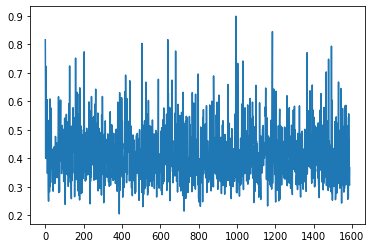

In [270]:
plt.plot(losses)

## Implement training over batches 
Try K-fold CV

In [271]:
import sklearn
from sklearn.model_selection import KFold
k_folds = 5
num_epochs = 1

In [272]:
# Copied from reference notebook
kfold = KFold(5, shuffle = True, random_state = 12345)

scores = []
for fold, (tr_idx, va_idx) in enumerate(kfold.split(X_torch, Adj_torch)):
    print(f"------ fold {fold} start -----")
    X_node_tr = X_torch[tr_idx]
    X_node_va = X_torch[va_idx]
    As_tr = Adj_torch[tr_idx]
    As_va = Adj_torch[va_idx]
    y_tr = y_train[tr_idx]
    y_va = y_train[va_idx]
    
    model = GNN(hidden_channels=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adjust learning rate
    criterion = MCRMSE_single # Mean column-wise root mean square error (MCRMSE) loss
    for epoch in range(0, num_epochs):
        print(f"epoch : {epoch + 1}")
        current_loss = 0.
        for ix in range(len(X_node_tr)):
            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(X_node_tr[ix,:,:], As_tr[ix,:,:]) # Perform a single forward pass.

            # Compute loss
            loss = criterion(torch.tensor(y_tr[ix,:,:].astype(float)), outputs)  # Compute the loss. Convert target vector to float (apparently important for back-propagation)
            
            # Perform backward pass
            loss.backward()
            
            # Perform optimization
            optimizer.step()
            
            # Print statistics
            current_loss += loss.item()
            if ix % 200 == 199:
                print('Loss after mini-batch %5d: %.3f' %
                    (ix + 1, current_loss / 200))
                current_loss = 0.0

        # Process is complete.
        print('Training process has finished. Saving trained model.')

        # Print about testing
        print('Starting testing')
    
        # Saving the model
        save_path = f'./model-fold-{fold}.pth'
        torch.save(model.state_dict(), save_path)

        # Evaluation for this fold
        total = 0
        num_vals = 0
        with torch.no_grad():

             # Iterate over the test data and generate predictions
            for jx in range(len(X_node_va)):

                # Generate outputs
                outputs = model(X_node_va[jx,:,:], As_va[jx,:,:]) # Perform a single forward pass.

                # Save scores and predictions
                val_loss = criterion(torch.tensor(y_va[jx,:,:].astype(float)), outputs)
                scores.append(val_loss.item())
                total += val_loss.item()
                num_vals += 1

            # Print accuracy
            print(f'Average loss for fold {fold}: {total/num_vals}')
            print('--------------------------------')
        
        


------ fold 0 start -----
epoch : 1
Loss after mini-batch   200: 0.430
Loss after mini-batch   400: 0.419
Loss after mini-batch   600: 0.418
Loss after mini-batch   800: 0.411
Loss after mini-batch  1000: 0.414
Loss after mini-batch  1200: 0.409
Training process has finished. Saving trained model.
Starting testing
Average loss for fold 0: 0.4119199082722222
--------------------------------
------ fold 1 start -----
epoch : 1
Loss after mini-batch   200: 0.434
Loss after mini-batch   400: 0.414
Loss after mini-batch   600: 0.412
Loss after mini-batch   800: 0.411
Loss after mini-batch  1000: 0.416
Loss after mini-batch  1200: 0.420
Training process has finished. Saving trained model.
Starting testing
Average loss for fold 1: 0.4027339992260793
--------------------------------
------ fold 2 start -----
epoch : 1
Loss after mini-batch   200: 0.435
Loss after mini-batch   400: 0.426
Loss after mini-batch   600: 0.411
Loss after mini-batch   800: 0.410
Loss after mini-batch  1000: 0.411
Los

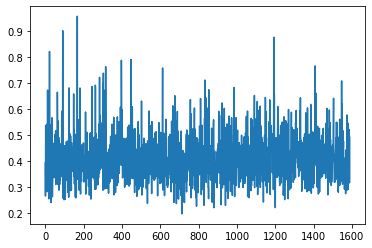

In [273]:
plt.plot(scores)

### To do / log:
* Reflect on what types of GNN models might be of interest for our project. GraphConv?
* Do our own EDA, write out conclusions and ideas in notebook (work in progress)
* Understand data, understand GNN, connect the two

* Look at signal to noise, and SN filter. Should these be excluded/treated differently in training?
* Reference notebook uses `structure` as node features. I do not see how this should improve the model, as the information from `structure` is already included in the structure adjacency matrix and the predicted loop type (`"("` and `")"` correspond to loop type `"S"`).
* Reference notebook also uses an "interaction" node feature. Maybe look up in literature what this is, and if it seems interesting to include. * On second thought, this does not seem to have any physical interpretation. Could look at 4th place solution for some more reasonable node feature ideas.

13/5
* Implement a simple GNN to go from arbitrary adjacency matrix A and node feature matrix X to targets Y.
* For now, write a function that performs the GraphConv operation, as it is a quite simple function. 
* For future testing, install torch-geometric for ready implemented graph neural network functions. (Had some issues with CUDA and installation)
* Decide if we in training iterate over samples, take all at once, or use smaller batches. (Probably batches with some k-fold validation)
* Ran into some problems with tensor/numpy and float/double. Clean up code to find the mistakes.

For next time:
* Fix the errors with 'input must be tensor'/'expected float, got double', should be able to get model output after that. 
* Continue writing training function and make inference
* When all of this works without errors, start improving the model/input features/training routine etc.

14/5
* Float/double issue solved by calling astype(float) on inputs (X and adjacency)
* Input must be tensor issue solved by adding the nn.ReLU module instead of using relu from torch.nn.functional (not sure why this helped)
* Should rewrite myGraphConv to take input shape (n_samples, n_nodes, n_features) so that one can iterate over batches rather than only single samples
* Once things work, clean up the code/variable names and paste into main notebook/script.
* Take a look at training loss, does not seem to actually train. Could be some problem with myGraphConv, when doing backpropagation. Or that it is just a poor model. Maybe try using a simple multi-layer perceptron model to see if that is as bad. 
* Implement training over mini-batches. Need to adjust myGraphConv.

17/5
* Tried to include distance matrix. Results seem to get slightly better, but not significantly
* Tried to implement cross validation. It works, but we still have the same problem with training loss being erratic.
* The model does not seem to actually learn during training, loss varies irregularly during training. Is this due to a mistake in implementation, or simply because inference is hard for the data.
* Have not commited any of these changes. Best idea is probably to gather all the useful parts of the notebook in a separate script, to improve readability and allow for easier testing.
* Idea: Test using same implementation as reference notebook. GraphConv layer outputs with shape (samples, nodes, node_features, edge_features) and apply Conv1D to go from (, edge_features) to (,1).
* Added line of code when loading data to allow for only using SN-filtered data. The training loss becomes much lower when doing this, the question is what happens with the test loss.
* To do: load the post deadline files, write code so that the public test loss is evaluated for the final model, to see if we're on the right track. (This is similar to making a Kaggle submission to the Public leaderboard, which I think was available during the competition).

For next time:
* Load post deadline files, include public test score to see how we're doing.
* Try out different ways of including multiple edge features (adjacency matrices). Current ideas:
    * One term for each adjacency matrix, with separate weight matrices (current implementation in GNN_test)
    * Add dimension representing edge features (like in reference notebook), concatenate this dimension after the GraphConv layer, for example using Conv1D (see reference notebook for example/ideas)
    * Add up all the adjacency matrices before applying GraphConv
    * Convert the adjacency matrices to edge index lists with corresponding edge weight arrays. Use GraphConv from torch-geometric (essentially expanding the adjacency matrix). (!!!) I think this is a good idea (!!!)
* Choose the model implementation that works the best. Clean up the code, try to make it easier to run predictions/training/tests. 
* If we have the time, 
    * tweak network architecture
    * try using GATConv layer 
    * look at simulating noise by adding estimated errors at random to data (see 1st place solution for example)
    * add bpps edge features
    * add node features, such as distance to nearest paired/non-paired node
    
